# ・PixieDuskとWatson MLを使用してレコメンデーションエンジンを作成しましょう

![](https://raw.githubusercontent.com/IBM/product-recommendation-with-watson-ml/master/doc/source/images/shopping.png)

このnotebookでは、購買履歴に基づくレコメンデーションモデルを作成するためのコードがステップbyステップで書かれています。
このモデルをWatson Machine Learningにデプロイし、PixieAppと連携させましょう。稼働環境はPython3系、Apache Spark 2.1です。


## Goal

このnotebookを通じて以下を実施します:

* CSVファイルをWatson Studioと連携しているObject Strageにロードします。
* レコメンデーションを作成するために、k平均法アルゴリズムを使用し、顧客セグメントをクラスター化します。
* モデルをWatsonMLにデプロイし、レコメンデーションアプリを作成します。

## Table of contents

1. [Setup](#setup)<br>
2. [データのロード](#load)<br>
3. [K平均モデルの作成](#kmeans)<br>
   3.1. [データの準備](#prepare_data)<br>
   3.2. [クラスターの作成およびモデルの定義](#build_model)<br>
4. [モデルの永続化](#persist)<br>
5. [IBM Cloudへのモデルのデプロイ](#deploy)<br>
   5.1. [デプロイメントの作成](#create_deploy)<br>
   5.2. [デプロイメントモデルのテスト](#test_deploy)<br>
6. [レコメンデーションの作成](#create_recomm)<br>
   6.1. [レコメンデーションモデルのテスト](#test_recomm)<br>
7. [まとめ](#summary)<br>

## 1. Setup

このnotebookを実行する前に、以下の事前準備が完了していることを確認してください。
Before you use the sample code in this notebook, you must perform the following setup tasks:

* Watson Machine LearningサービスとWatson Studioのプロジェクトが関連付けられている
* Create a Watson Machine Learning service instance (a free plan is offered) and associate it with your project


以下3種類のライブラリーを使用します:

1. [Watson Machine Learning Client](http://wml-api-pyclient.mybluemix.net/): Client library to work with the Watson Machine Learning service on IBM Cloud. Library available on [pypi](https://pypi.org/project/watson-machine-learning-client/). Service available on [IBM Cloud](https://cloud.ibm.com/catalog/services/machine-learning).
1. [Pixiedust](https://github.com/pixiedust/pixiedust): Python Helper library for Jupyter Notebooks. Available on [pypi](https://pypi.org/project/pixiedust/).
1. [ibmos2spark](https://github.com/ibm-watson-data-lab/ibmos2spark): Facilitates Data I/O between Spark and IBM Object Storage services

**[参考] pipとは？**: 

パッケージマネージャー。pip installコマンドでサードパーティーのライブラリーをインストール出来ます。

jupyter notebook上で実行する場合は、最初に"!"をつける必要があります。

In [2]:
!pip install --upgrade ibmos2spark
!pip install --upgrade pixiedust
!pip install --upgrade watson-machine-learning-client

    100% |################################| 204kB 4.7MB/s eta 0:00:01
    100% |################################| 798kB 4.0MB/s eta 0:00:01
    100% |################################| 5.8MB 2.2MB/s eta 0:00:01
    100% |################################| 92kB 6.0MB/s eta 0:00:01
    100% |################################| 61kB 3.6MB/s eta 0:00:01
    100% |################################| 583kB 5.0MB/s eta 0:00:01
    100% |################################| 153kB 6.1MB/s eta 0:00:01
    100% |################################| 163kB 6.3MB/s eta 0:00:01
    100% |################################| 61kB 4.2MB/s eta 0:00:01
    100% |################################| 143kB 6.4MB/s eta 0:00:01
  Stored in directory: /home/spark/shared/.cache/pip/wheels/25/fa/a5/09c1e8f4c91b34c5f7f4ac6e41be81dd0667030a2372546a8d
  Stored in directory: /home/spark/shared/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
Successfully built pixiedust mpld3
tensorflow 1.13.1 requires t

以下のimport文を実行することで、pixiedustをこの環境で使えるようにします。

``import XX as YY``

とすることで、YYという名前でXXをインポートすることも可能です。
例えば、非常に有名なライブラリであるpandasはpd、numpyはnpという名前でインポートすることが多いです。

In [3]:
import pixiedust

Pixiedust database opened successfully
Table VERSION_TRACKER created successfully
Table METRICS_TRACKER created successfully

Share anonymous install statistics? (opt-out instructions)

PixieDust will record metadata on its environment the next time the package is installed or updated. The data is anonymized and aggregated to help plan for future releases, and records only the following values:

{
   "data_sent": currentDate,
   "runtime": "python",
   "application_version": currentPixiedustVersion,
   "space_id": nonIdentifyingUniqueId,
   "config": {
       "repository_id": "https://github.com/ibm-watson-data-lab/pixiedust",
       "target_runtimes": ["Data Science Experience"],
       "event_id": "web",
       "event_organizer": "dev-journeys"
   }
}
You can opt out by calling pixiedust.optOut() in a new cell.


Pixiedust runtime updated. Please restart kernel
Table SPARK_PACKAGES created successfully
Table USER_PREFERENCES created successfully
Table service_connections created successfully


<a id="load"></a>
## 2. データのロード

このセクションでは、先程インポートしたPixieDustライブラリに用意されているsampleDataメソッドを使用し、顧客購買データをロードしていきます。

`pixiedust.sampleData("ファイルのURL")`

PixieDustの各メソッドの詳細については、[こちら](https://pixiedust.github.io/pixiedust)を参照。


In [4]:
#ロードしたデータをdfという名前の変数に代入
df = pixiedust.sampleData('https://raw.githubusercontent.com/IBM/product-recommendation-with-watson-ml/master/data/customers_orders1_opt.csv')

Downloaded 5648773 bytes
Creating pySpark DataFrame for 'https://raw.githubusercontent.com/IBM/product-recommendation-with-watson-ml/master/data/customers_orders1_opt.csv'. Please wait...
Loading file using 'SparkSession'
Successfully created pySpark DataFrame for 'https://raw.githubusercontent.com/IBM/product-recommendation-with-watson-ml/master/data/customers_orders1_opt.csv'


ロードしたデータは、`display`メソッドを使用しテーブル形式で表示できます。
単純にテーブル形式で表示するだけではなく、棒グラフ、散布図、パイチャートといった様々な形式で表示可能です。

In [5]:
display(df)

CUSTNAME,GenderCode,ADDRESS1,CITY,STATE,COUNTRY_CODE,POSTAL_CODE,POSTAL_CODE_PLUS4,ADDRESS2,EMAIL_ADDRESS,PHONE_NUMBER,CREDITCARD_TYPE,LOCALITY,SALESMAN_ID,NATIONALITY,NATIONAL_ID,CREDITCARD_NUMBER,DRIVER_LICENSE,CUST_ID,ORDER_ID,ORDER_DATE,ORDER_TIME,FREIGHT_CHARGES,ORDER_SALESMAN,ORDER_POSTED_DATE,ORDER_SHIP_DATE,AGE,ORDER_VALUE,T_TYPE,PURCHASE_TOUCHPOINT,PURCHASE_STATUS,ORDER_TYPE,GENERATION,Baby Food,Diapers,Formula,Lotion,Baby wash,Wipes,Fresh Fruits,Fresh Vegetables,Beer,Wine,Club Soda,Sports Drink,Chips,Popcorn,Oatmeal,Medicines,Canned Foods,Cigarettes,Cheese,Cleaning Products,Condiments,Frozen Foods,Kitchen Items,Meat,Office Supplies,Personal Care,Pet Supplies,Sea Food,Spices
Scott Lawson,Mr.,3105 Spadafore Drive,Antioch,WI,US,60002,0,None,Scott.M.Lawson@spambob.com,201-799-5873,JCB,None,SE133,CA,518957246,3528246880562026,None,10115,1059,2016-03-16 17:47:25,2016-03-16 17:47:25.375000,27.97,SW211,2016-03-16 17:47:25,05/08/2016,NA,127.03,In-Progress,Phone,Occasional,MediumValue,Gen_Z,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
Ahmed Richard,Mr.,1346 Carter Street,Appleton,WI,US,54911,0,None,Ahmed.P.Richard@mailinator.com,510-517-7759,JCB,None,SW214,U.S.,229990001,3528227807541624,None,10123,4564,2016-12-07 00:00:00,2016-12-07 08:43:52.556000,24.08,SW274,2016-01-22 00:00:00,25/01/2016,20,44.29,Complete,Phone,FirstTime,LowValue,Gen_Z,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
Harold Magee,Mr.,565 Cinnamon Lane,Ashland,VA,US,23005,0,None,Harold.A.Magee@mailinator.com,503-308-1831,American Express,None,NW310,UK,YS731666A,349153333997514,None,10155,8974,2016-12-25 00:00:00,2016-12-25 09:32:50.756000,17.6,NW247,2016-01-09 00:00:00,15/01/2016,40,40.62,Complete,Phone,Occasional,LowValue,Gen_Y,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Ivan Case,Mr.,2540 School Street,Athens,TX,US,75751,0,None,Ivan.J.Case@dodgeit.com,512-391-4111,Diners Club,None,SC130,U.S.,23868154,36184034250365,None,10163,1740,2016-06-11 00:00:00,2016-06-11 15:36:44.886000,13.33,RP319,2016-07-10 00:00:00,20/07/2016,27,282.85,In-Progress,Phone,FirstTime,HighValue,Gen_Y,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1,1
Arlene Cruz,Mrs.,4858 Bottom Lane,Auburn,WA,US,98002,0,None,Arlene.M.Cruz@mailinator.com,817-905-6598,JCB,None,SW211,IT,CQQVJC41M50H989G,3528504942772615,None,10183,6950,2016-05-11 00:00:00,2016-05-11 21:27:55.556000,10.45,SW217,2016-05-30 00:00:00,10/06/2016,35,42.66,Complete,Phone,Occasional,LowValue,Gen_Y,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Yasmin Cole,Mrs.,2756 Johnson Street,Austin,TX,US,78664,0,None,Yasmin.D.Cole@pookmail.com,703-633-1911,VISA,None,NC424,ES,1062903G,4761926230870401,None,10195,1210,2016-08-01 00:00:00,2016-08-01 15:29:06.250000,23.37,SW406,2016-10-15 00:00:00,03/11/2016,68,9999999.0,Complete,Desktop,Occasional,HighValue,Baby_Boomers,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1
Frank Westra,Mr.,3540 Stout Street,Baton Rouge,LA,US,70806,0,None,Frank.K.Westra@spambob.com,661-947-3606,VISA,None,NW376,FR,7.39E+14,4454480768357565,None,10259,8175,2016-02-29 00:00:00,2016-02-29 22:39:06.250000,6.87,SE331,2016-03-17 00:00:00,27/03/2016,24,16.94,In-Progress,Phone,FirstTime,LowValue,Gen_Y,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
Tony Brooks,Mr.,2134 Watson Lane,Bergotto,PR,IT,43042,0,None,Tony.D.Brooks@mailinator.com,0357 7464003,American Express,None,SW277,CA,935314484,373016812700594,None,10303,4184,2016-04-30 00:00:00,2016-04-30 01:02:36.564000,22.77,NE235,2016-05-19 00:00:00,29/05/2016,22,190.12,Complete,Phone,Occasional,HighValue,Gen_Z,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1
Margaret Shelton,Mrs.,1034 Briarwood Drive,Birmingham,AL,US,35222,0,None,Margaret.T.Shelton@pookmail.com,860-435-8672,Discover,None,WE283,CA,944146232,6011069993251007,None,10335,7464,2016-04-14 00:00:00,2016-04-14 07:32:45.116000,48.52,NE301,2016-07-23 00:00:00,12/08/2016,45,31.71,Complete,Phone,Occasional,LowValue,Gen_X,0,0,0,0,0,0,0,0,

<a id="kmeans"></a>
## 3. Sparkを使用したK平均モデルの作成

このセクションでは、K平均法アルゴリズムを使用し、各顧客を購買履歴をもとにクラスタリングしていきます。
In this section of the notebook you use the *k*-means implementation to associate every customer to a cluster based on their shopping history.

はじめに、Apache Spark Machine Learning パッケージ([MLlib](http://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html)) をインポートします。
First, import the Apache Spark Machine Learning packages ([MLlib](http://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html)) that you need in the subsequent steps:


`from モジュール名 import オブジェクト名`


In [6]:
# pyspark.mlモジュールから、Pipelineオブジェクトをインポート
from pyspark.ml import Pipeline

#同様に、今後使用するオブジェクトもインポート
from pyspark.ml.clustering import KMeans
from pyspark.ml.clustering import KMeansModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors

<a id="prepare_data"></a>
### 3.1 データの準備

必要なデータだけを使用して、新しいデータセットを作成します。データモデルの学習に必要な列だけをフィルターすることで使用しない列を取り除いていきます。 今回は、顧客ID、商品の列のみをフィルターします。
Create a new data set with just the data that you need. Filter the columns that you want, in this case the customer ID column and the product-related columns. Remove the columns that you don't need for aggregating the data and training the model:

In [7]:
# 商品列を配列として定義します
product_cols = ['Baby Food', 'Diapers', 'Formula', 'Lotion', 'Baby wash', 'Wipes', 'Fresh Fruits', 'Fresh Vegetables', 'Beer', 'Wine', 'Club Soda', 'Sports Drink', 'Chips', 'Popcorn', 'Oatmeal', 'Medicines', 'Canned Foods', 'Cigarettes', 'Cheese', 'Cleaning Products', 'Condiments', 'Frozen Foods', 'Kitchen Items', 'Meat', 'Office Supplies', 'Personal Care', 'Pet Supplies', 'Sea Food', 'Spices']
# selectメソッドを使用して顧客ID、商品情報のデータのみを抽出します
df_filtered = df.select(['CUST_ID'] + product_cols)

フィルターしたデータを使用して`display()`を実行してみましょう :

In [10]:
display(df_filtered)

CUST_ID,Baby Food,Diapers,Formula,Lotion,Baby wash,Wipes,Fresh Fruits,Fresh Vegetables,Beer,Wine,Club Soda,Sports Drink,Chips,Popcorn,Oatmeal,Medicines,Canned Foods,Cigarettes,Cheese,Cleaning Products,Condiments,Frozen Foods,Kitchen Items,Meat,Office Supplies,Personal Care,Pet Supplies,Sea Food,Spices
10015,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
10039,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0
10055,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1
10139,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
10171,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
10283,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
10327,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1
10351,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1
10599,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
10667,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


次に、各顧客の個々の購買情報を集計して、製品ごと、顧客ごとに単一のスコアを取得します。

In [ ]:
#df_customer_products = df_filtered.groupby('CUST_ID').sum()
# Use customer IDs to group transactions by customer and sum them up
display(df_customer_products)
# df_customer_products = df_customer_products.drop('sum(CUST_ID)')
display(df_customer_products)

CUST_ID,sum(CUST_ID),sum(Baby Food),sum(Diapers),sum(Formula),sum(Lotion),sum(Baby wash),sum(Wipes),sum(Fresh Fruits),sum(Fresh Vegetables),sum(Beer),sum(Wine),sum(Club Soda),sum(Sports Drink),sum(Chips),sum(Popcorn),sum(Oatmeal),sum(Medicines),sum(Canned Foods),sum(Cigarettes),sum(Cheese),sum(Cleaning Products),sum(Condiments),sum(Frozen Foods),sum(Kitchen Items),sum(Meat),sum(Office Supplies),sum(Personal Care),sum(Pet Supplies),sum(Sea Food),sum(Spices)
11317,22634,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
15254,61016,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2,0,0,0,0,0,2,0,0,0,0,2
15382,15382,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
10395,20790,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,1,0
14458,72290,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,2,1,0,1,2,0,0,1,0,0,0,0,1
10947,21894,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11894,11894,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
14058,28116,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15491,61964,0,0,0,0,0,0,0,0,0,0,3,0,3,2,0,0,3,0,0,0,3,0,0,0,0,0,0,0,0
11059,22118,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<a id="build_model"></a>
### 3.2 Create clusters and define the model 

Create 100 clusters with a *k*-means model based on the number of times a specific customer purchased a product.

| No Clustering | Clustering |
|------|------|
|  ![](https://raw.githubusercontent.com/IBM/product-recommendation-with-watson-ml/master/doc/source/images/kmeans-1.jpg)  | ![](https://raw.githubusercontent.com/IBM/product-recommendation-with-watson-ml/master/doc/source/images/kmeans-2.jpg) |

First, create a feature vector by combining the product and quantity columns:

In [ ]:
assembler = VectorAssembler(inputCols=["sum({})".format(x) for x in product_cols],outputCol="features") # Assemble vectors using product fields

Next, create the *k*-means clusters and the pipeline to define the model:

In [ ]:
kmeans = KMeans(maxIter=50, predictionCol="cluster").setK(100).setSeed(1)  # Initialize model
pipeline = Pipeline(stages=[assembler, kmeans])
model = pipeline.fit(df_customer_products)

Finally, calculate the cluster for each customer by running the original dataset against the *k*-means model: 

In [ ]:
df_customer_products_cluster = model.transform(df_customer_products)
display(df_customer_products_cluster)

<a id="persist"></a>
## 4. モデルの永続化

このセクションでは、作成したパイプラインとモデルを、WatsonMLリポジトリーに保存する方法を学びます。

### 4.1Watson ML 資格情報のセットアップ

プログラムからWatson MLリポジトリーにアクセスするため、資格情報をコピーする必要があります。
To access your machine learning repository programmatically, you need to copy in your credentials, which you can see in your **IBM Watson Machine Learning** service details in IBM Cloud.

> **IMPORTANT**: 以下のセル内で、 `apikey` と `instance_id` の値を自分の資格情報に更新してください。資格情報はWatson Maschine Learningサービス内にある資格情報タブで取得できます。

・資格情報タブをクリック
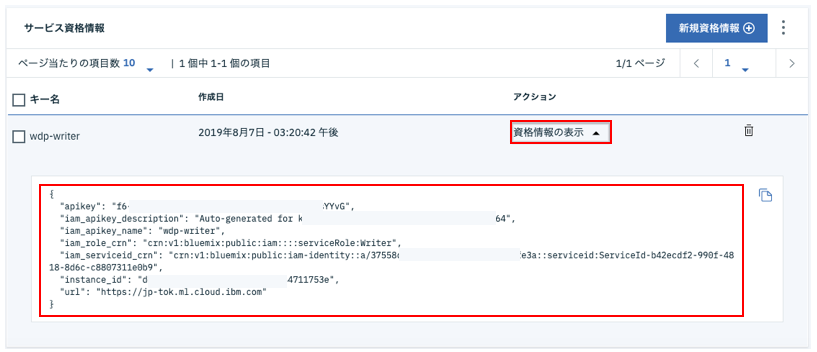

・サービス資格情報内で、資格情報を表示をクリック
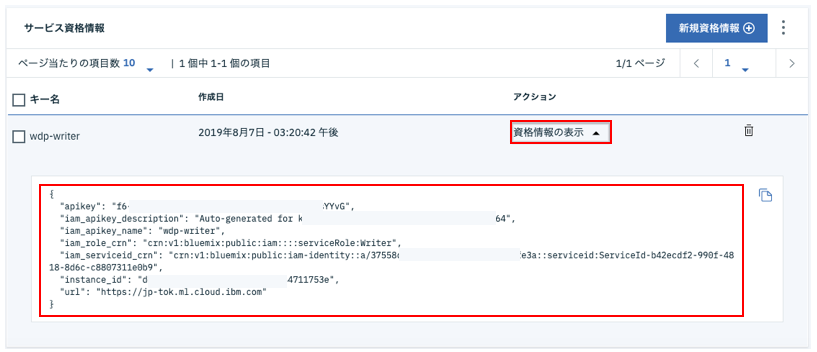


In [ ]:
# The code was removed by Watson Studio for sharing.

上のセルで更新ｎした資格情報を使用して、Watson Machine Learning サービスと接続します。

setupでインストールした`watson_machine_learning_client`モジュールから、WatsonMachineLearningAPIClientオブジェクトをインポートします。
このオブジェクトには、WatsonMLとやりとりするための各種APIが用意されています。

In [ ]:
# WatsonMachineLearningAPIClientをインポート
from watson_machine_learning_client import WatsonMachineLearningAPIClient

#資格情報を使用して、APIClientをclientという名前でインスタンス化
client = WatsonMachineLearningAPIClient(wml_credentials)
print(client.version)

### 4.2 モデルの保存

#### モデルをWatsonMLリポジトリーに保存します

Watson ML Clientの [Repository class](http://wml-api-pyclient.mybluemix.net/#repository) を使用してモデルの保存を実行します。

> **NOTE**: Clientツールを使用する代わりに、Watson Studio上でモデルを管理することも出来ます。

In [ ]:
train_data = df_customer_products.withColumnRenamed('CUST_ID', 'label')

> **TIP**: モデルに関する情報をメタデータとして保存できます。下のセルでは、モデル作成者をIBMという名前でメタデータとして追加しています。
3-2で作成したモデルとパイプラインにメタデータを追加してWatsonMLリポジトリーに保存します。

In [ ]:
model_props = {client.repository.ModelMetaNames.AUTHOR_NAME: "IBM", 
               client.repository.ModelMetaNames.NAME: "Shopping Recommendation Engine"}

# 3-2で作成したモデルとパイプラインにメタデータを追加してWatsonMLリポジトリーに保存します。
published_model = client.repository.store_model(model=model, pipeline=pipeline, meta_props=model_props, training_data=train_data)

> **NOTE**: `client.repository.delete`メソッドを使用することでモデルを削除することが出来ます。

#### WatsonMLリポジトリーに保存されているモデルの一覧を取得しましょう

In [ ]:
client.repository.list_models()

#### 保存したモデルの詳細情報を表示してみましょう。

下のセルでは以下のステップで詳細情報を取得しています。
1. get_model_uidメソッドでモデルのuid(ユニークID）を取得
2. 取得したuidを使用してget_detailメソッドを実行することでモデルの詳細情報を取得
3. json形式で出力

In [ ]:
#jsonモジュールをインポート
import json

saved_model_uid = client.repository.get_model_uid(published_model)
model_details = client.repository.get_details(saved_model_uid)
print(json.dumps(model_details, indent=2))

<a id="deploy"></a>
## 5. IBM cloudへのモデルのデプロイ

モデルをデプロイするために、Watson ML Clientの [Deployments class](http://wml-api-pyclient.mybluemix.net/#deployments) を使用します。

### 5.1 デプロイメントの作成


In [ ]:
created_deployment = client.deployments.create(saved_model_uid, 'Shopping Recommendation Engine Deployment')

### 5.2 エンドポイントの作成

In [ ]:
scoring_endpoint = client.deployments.get_scoring_url(created_deployment)
print(scoring_endpoint)

<a id="test_deploy"></a>
### 5.3 デプロイメントのテスト

To verify that the model was successfully deployed to the cloud, you'll specify a customer ID, for example customer 12027, to predict this customer's cluster against the Watson Machine Learning deployment, and see if it matches the cluster that was previously associated this customer ID.

In [ ]:
customer = df_customer_products_cluster.filter('CUST_ID = 12027').collect()
print("Previously calculated cluster = {}".format(customer[0].cluster))

To determine the customer's cluster using Watson Machine Learning, you need to load the customer's purchase history. This function uses the local data frame to select every product field and the number of times that customer 12027 purchased a product.

In [ ]:
from six import iteritems
def get_product_counts_for_customer(cust_id):
    cust = df_customer_products.filter('CUST_ID = {}'.format(cust_id)).take(1)
    fields = []
    values = []
    for row in customer:
        for product_col in product_cols:
            field = 'sum({})'.format(product_col)
            value = row[field]
            fields.append(field)
            values.append(value)
    return (fields, values)

This function takes the customer's purchase history and calls the scoring endpoint:

In [ ]:
def get_cluster_from_watson_ml(fields, values):
    scoring_payload = {'fields': fields, 'values': [values]}
    predictions = client.deployments.score(scoring_endpoint, scoring_payload)   
    return predictions['values'][0][len(product_cols)+1]

Finally, call the functions defined above to get the product history, call the scoring endpoint, and get the cluster associated to customer 12027:

In [ ]:
product_counts = get_product_counts_for_customer(12027)
fields = product_counts[0]
values = product_counts[1]
print("Cluster calculated by Watson ML = {}".format(get_cluster_from_watson_ml(fields, values)))

<a id="create_recomm"></a>
## 6. レコメンデーションの作成

最後に、公開したモデルを使用したレコメンデーションアプリを作成しましょう！

まずは、次のセルを実行し、
First, run this cell to create a function that queries the database and finds the most popular items for a cluster. In this case, the **df_customer_products_cluster** dataframe is the database.

In [ ]:
# This function gets the most popular clusters in the cell by grouping by the cluster column
def get_popular_products_in_cluster(cluster):
    df_cluster_products = df_customer_products_cluster.filter('cluster = {}'.format(cluster))
    df_cluster_products_agg = df_cluster_products.groupby('cluster').sum()
    row = df_cluster_products_agg.rdd.collect()[0]
    items = []
    for product_col in product_cols:
        field = 'sum(sum({}))'.format(product_col)
        items.append((product_col, row[field]))
    sortedItems = sorted(items, key=lambda x: x[1], reverse=True) # Sort by score
    popular = [x for x in sortedItems if x[1] > 0]
    return popular

Now, run this cell to create a function that will calculate the recommendations based on a given cluster. This function finds the most popular products in the cluster, filters out products already purchased by the customer or currently in the customer's shopping cart, and finally produces a list of recommended products.

In [ ]:
# This function takes a cluster and the quantity of every product already purchased or in the user's cart
from pyspark.sql.functions import desc
def get_recommendations_by_cluster(cluster, purchased_quantities):
    # Existing customer products
    print('PRODUCTS ALREADY PURCHASED/IN CART:')
    customer_products = []
    for i in range(0, len(product_cols)):
        if purchased_quantities[i] > 0:
            customer_products.append((product_cols[i], purchased_quantities[i]))
    df_customer_products = sc.parallelize(customer_products).toDF(["PRODUCT","COUNT"])
    df_customer_products.show()
    # Get popular products in the cluster
    print('POPULAR PRODUCTS IN CLUSTER:')
    cluster_products = get_popular_products_in_cluster(cluster)
    df_cluster_products = sc.parallelize(cluster_products).toDF(["PRODUCT","COUNT"])
    df_cluster_products.show()
    # Filter out products the user has already purchased
    print('RECOMMENDED PRODUCTS:')
    df_recommended_products = df_cluster_products.alias('cl').join(df_customer_products.alias('cu'), df_cluster_products['PRODUCT'] == df_customer_products['PRODUCT'], 'leftouter')
    df_recommended_products = df_recommended_products.filter('cu.PRODUCT IS NULL').select('cl.PRODUCT','cl.COUNT').sort(desc('cl.COUNT'))
    df_recommended_products.show(10)

Next, run this cell to create a function that produces a list of recommended items based on the products and quantities in a user's cart. This function uses Watson Machine Learning to calculate the cluster based on the shopping cart contents and then calls the **get_recommendations_by_cluster** function.

In [ ]:
# This function would be used to find recommendations based on the products and quantities in a user's cart
def get_recommendations_for_shopping_cart(products, quantities):
    fields = []
    values = []
    for product_col in product_cols:
        field = 'sum({})'.format(product_col)
        if product_col in products:
            value = quantities[products.index(product_col)]
        else:
            value = 0
        fields.append(field)
        values.append(value)
    return get_recommendations_by_cluster(get_cluster_from_watson_ml(fields, values), values)

Run this cell to create a function that produces a list of recommended items based on the purchase history of a customer. This function uses Watson Machine Learning to calculate the cluster based on the customer's purchase history and then calls the **get_recommendations_by_cluster** function.

In [ ]:
# This function is used to find recommendations based on the purchase history of a customer
def get_recommendations_for_customer_purchase_history(customer_id):
    product_counts = get_product_counts_for_customer(customer_id)
    fields = product_counts[0]
    values = product_counts[1]
    return get_recommendations_by_cluster(get_cluster_from_watson_ml(fields, values), values)

Now you can take customer 12027 and produce a recommendation based on that customer's purchase history:

In [ ]:
get_recommendations_for_customer_purchase_history(12027)

Now, take a sample shopping cart and produce a recommendation based on the items in the cart:

In [ ]:
get_recommendations_for_shopping_cart(['Diapers','Baby wash','Oatmeal'],[1,2,1])

The next optional section outlines how you can easily expose recommendations to notebook users, for example for test purposes.

<a id="test_recomm"></a>
### 6.1 Test product recommendations model

You can interactively test your product recommendations model using a simple PixieApp. [PixieApps](https://pixiedust.github.io/pixiedust/pixieapps.html) encapsulate business logic and data visualizations, making it easy for notebook users to explore data without having to write any code. Typically these applications are pre-packaged and imported into a notebook. However, for illustrative purposes we've embedded the product recommendation source code in this notebook.

![](https://raw.githubusercontent.com/IBM/product-recommendation-with-watson-ml/master/doc/source/images/product_recommendation_app.png")

Run the cell below, add items to the shopping cart and click the _Refresh_ button to review the recommendation results.

In [ ]:
# This function takes a cluster and the quantity of every product already purchased or in the user's cart & returns the data frame of recommendations for the PixieApp
from pyspark.sql.functions import desc
def get_recommendations_by_cluster_app(cluster, purchased_quantities):
    # Existing customer products
    customer_products = []
    for i in range(0, len(product_cols)):
        if purchased_quantities[i] > 0:
            customer_products.append((product_cols[i], purchased_quantities[i]))
    df_customer_products = sc.parallelize(customer_products).toDF(["PRODUCT","COUNT"])
    # Get popular products in the cluster
    cluster_products = get_popular_products_in_cluster(cluster)
    df_cluster_products = sc.parallelize(cluster_products).toDF(["PRODUCT","COUNT"])
    # Filter out products the user has already purchased
    df_recommended_products = df_cluster_products.alias('cl').join(df_customer_products.alias('cu'), df_cluster_products['PRODUCT'] == df_customer_products['PRODUCT'], 'leftouter')
    df_recommended_products = df_recommended_products.filter('cu.PRODUCT IS NULL').select('cl.PRODUCT','cl.COUNT').sort(desc('cl.COUNT'))
    return df_recommended_products


# PixieDust sample application

from pixiedust.display.app import *

@PixieApp
class RecommenderPixieApp:
    def setup(self):
        self.product_cols = product_cols
        
    def computeUserRecs(self, shoppingcart):   
        #format products and quantities from shopping cart display data
        lst = list(zip(*[(item.split(":")[0],int(item.split(":")[1])) for item in shoppingcart.split(",")]))
        products = list(lst[0])
        quantities = list(lst[1])
        #format for the Model function
        lst = list(zip(*[('sum({})'.format(item),quantities[products.index(item)] if item in products else 0) for item in self.product_cols]))
        fields = list(lst[0])
        values = list(lst[1])
        #call the run Model function
        recommendations_df = get_recommendations_by_cluster_app(get_cluster_from_watson_ml(fields, values), values)
        recs = [row["PRODUCT"] for row in recommendations_df.rdd.collect()]
        return recs[:5]
    
    @route(shoppingCart="*")
    def _recommendation(self, shoppingCart):
        recommendation = self.computeUserRecs(shoppingCart)
        self._addHTMLTemplateString(
        """
        <table style="width:100%"> {% for item in recommendation %} <tr> <td type="text" style="text-align:left">{{item}}</td> </tr> {% endfor %} </table>
        """, recommendation = recommendation)

        
    @route()
    def main(self):
        return """
        <script>
        function getValuesRec(){
            return $( "input[id^='prod']" )
            .filter(function( index ) {
                return parseInt($(this).val()) > 0;})
            .map(function(i, product) {
                return $(product).attr("name") + ":" + $(product).val();
            }).toArray().join(",");}
            
        function getValuesCart(){
            return $( "input[id^='prod']" )
            .filter(function( index ) {
                return parseInt($(this).val()) > 0; })
            .map(function(i, product) {
                return $(product).attr("name") + ":" + $(product).val();
            }).toArray(); }
        
        function populateCart(field) {
            user_cart = getValuesCart();
            $("#user_cart{{prefix}}").html("");
            if (user_cart.length > 0) {
                for (var i in user_cart) {
                    var item = user_cart[i];
                    var item_arr = item.split(":")
                    $("#user_cart{{prefix}}").append('<tr><td style="text-align:left">'+item_arr[1]+" "+item_arr[0]+"</td></tr>"); } }
            else { $("#user_cart{{prefix}}").append('<tr><td style="text-align:left">'+ "Cart Empty" +"</td></tr>"); } }
        
        function increase_by_one(field) {
            nr = parseInt(document.getElementById(field).value);
            document.getElementById(field).value = nr + 1;
            populateCart(field); }
        
        function decrease_by_one(field) {
            nr = parseInt(document.getElementById(field).value);
            if (nr > 0) { if( (nr - 1) >= 0) { document.getElementById(field).value = nr - 1; } }
            populateCart(field); } 
        </script>
        
        <table> Products: {% for item in this.product_cols %}
            {% if loop.index0 is divisibleby 4 %} <tr> {% endif %}
                <div class="prod-quantity">
                <td class="col-md-3">{{item}}:</td><td><input size="2" id="prod{{loop.index}}{{prefix}}" class="prods" type="text" 
                    style="text-align:center" value="0" name="{{item}}" /></td>
                <td><button onclick="increase_by_one('prod{{loop.index}}{{prefix}}');">+</button></td>
                <td><button onclick="decrease_by_one('prod{{loop.index}}{{prefix}}');">-</button></td>
                </div>
            {% if ((not loop.first) and (loop.index0 % 4 == 3)) or (loop.last) %} </tr> {% endif %}
        {% endfor %} </table>
        
        <div class="row">
            <div class="col-sm-6"> Your Cart: </div>
            <div class="col-sm-6"> Your Recommendations: <button pd_options="shoppingCart=$val(getValuesRec)" pd_target="recs{{prefix}}"> 
                <pd_script type="preRun"> if (getValuesRec()==""){alert("Your cart is empty");return false;} return true;
                </pd_script>Refresh </button> 
            </div>
        </div>
        
        <div class="row">
        <div class="col-sm-3"> <table style="width:100%" id="user_cart{{prefix}}"> </table> </div> <div class="col-sm-3"> </div>
        <div class="col-sm-3" id="recs{{prefix}}" pd_loading_msg="Calling your model in Watson ML"></div> <div class="col-sm-3"> </div>
        </div>
        """
        
    

#run the app
RecommenderPixieApp().run(runInDialog='false')

## <font color=green>Congratulations</font>, you've sucessfully created a recommendation engine, deployed it to the Watson Machine Learning service, and created a PixieApp!

You can now switch to the Watson Machine Learning console to deploy the model and then test it in application, or continue within the notebook to deploy the model using the APIs.